## 다이나믹 프로그래밍
다음 환경(**GridWorldEnvironment**)을 가지고 가치 이터레이션, 정책 이터레이션을 구현하세요.

## GridWorldEnvironment
```py
start_point = (0,0)
end_point = (4,4)
gridworld_size = (5,5)
env = GridWorldEnvironment(start_point, end_point, grid_world_size)
```

## Original Code

In [ ]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, grid_world_size:Tuple):

        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (grid_world_size[0] + end_point[0],
                                                                 grid_world_size[1] + end_point[1])
          # 상대 위치 계산시 (-1,-1) -> 좌상단(0,0)에서 오른쪽 1칸, 아래쪽 1칸 떨어진 곳

        # 그리드 월드의 규격을 받는다. (격저 크기 저장)
        self.width, self.height = grid_world_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right'] # 동작 리스트 저장
        self.num_actions = len(self.action_space) # 행동 개수 저장
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) } # 행동과 이동 벡터 매핑

        # 상태 : 좌표로 나타남
        self.traces = [] # 지금까지 지나온 위치 기록

        # total states
        self.total_states = [] # 격자판의 모든 위치를 담을 곳
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist()
        self.reward[end_point[0]][end_point[1]] = 1

    def render(self):
        # 그리드 월드의 상태를 시각적으로 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist() # 격자판 초기화

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 지나온 곳은 제거
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point 표시
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point 표시
        self.grid_world[last_point[0]][last_point[1]] = "A" # 에이전트의 현재 위치 표시

        # 격자 상태를 string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)

    def get_reward(self, state, action_idx): # 입력: 현재 위치, 행동 -> 출력: 보상
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]

    def state_after_action(self, state, action_idx:int): # 어떤 위치로 이동하는지 계산
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state

    def check_boundary(self, state):
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

## Own Code
위 환경 클래스를 상속 받아 `env.render` 코드를 구현하세요.

In [ ]:
class MyGridWorldEnv(GridWorldEnvironment):
  def render(self):

    grid_display = [['.' for _ in range(self.width)] for _ in range(self.height)]

    traces = list(set(self.traces))
    for trace in traces:
      grid_display[trace[0]][trace[1]] = 'X'

    last_point = self.traces[-1]
    grid_display[last_point[0]][last_point[1]] = 'A'
    grid_display[self.start_point[0]][self.start_point[1]] = 'S'
    grid_display[self.end_point[0]][self.end_point[1]] = 'G'

    print("Current Evironment: ")
    for row in grid_display:
      print(' '.join(row))
    print()

# 01. 정책 이터레이션
- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.

In [ ]:
class PolicyIteration:
    def __init__(self,env):
        # about env
        self.env = env
        self.action_space = env.action_space
        self.num_action = len(self.action_space)

        # value 2d list
        self.value_table = np.zeros(shape = (env.height, env.width)).tolist()

        # 상하좌우 동일한 확률을 가지는 정책으로 초기화
        self.policy_table = np.full(shape = (env.height, env.width, self.num_action), fill_value = 1/self.num_action).tolist()

        # end state 에서는 어떠한 행동도 할 필요가 없어서 policy table을 비운다.
        self.policy_table[env.end_point[0]][env.end_point[1]] = []

        self.gamma = 0.9 # 할인율

    def get_policy(self, state):
        action_probs = self.policy_table[state[0]][state[1]]

        max_idx = np.argmax(action_probs)
        return max_idx

    def get_value(self, state):
        return self.value_table[state[0]][state[1]]

    def get_action(self,state):
        probs = self.policy_tabel[state[0]][state[1]]
        action = np.random.choice(self.num_action, p = probs)
        return action

    def policy_evaluation(self):
        threshold = 1e-4
        while True:
          delta = 0
          for r in range(self.env.height):
            for c in range(self.env.width):
              if (r,c) == tuple(self.env.end_point): continue
              old_val = self.value_table[r][c]
              new_val = 0
              if len(self.policy_table[r][c]) == 0:
                continue
              for a in range(self.num_action):
                prob = self.policy_table[r][c][a]
                next_state = self.env.state_after_action((r,c), a)
                reward = self.env.get_reward(next_state, a)
                new_val += prob * (reward + self.gamma * self.value_table[next_state[0]][next_state[1]])
              self.value_table[r][c] = new_val
              delta = max(delta, abs(old_val - new_val))
          if delta < threshold:
            break

    def policy_improvement(self):
        policy_stable = True
        for r in range(self.env.height):
          for c in range(self.env.width):
            if (r,c) == tuple(self.env.end_point): continue

            old_action = np.argmax(self.policy_table[r][c]) if len(self.policy_table[r][c]) > 0 else 0
            action_values = []

            for a in range(self.num_action):
              next_state = self.env.state_after_action((r,c), a)
              reward = self.env.get_reward(next_state, a)
              q_value = reward + self.gamma * self.value_table[next_state[0]][next_state[1]]
              action_values.append(q_value)
            new_action = np.argmax(action_values)

            if new_action != old_action:
              policy_stable = False
            new_policy = [0] * self.num_action
            new_policy[new_action] = 1
            self.policy_table[r][c] = new_policy

        return policy_stable

## 정책 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

In [ ]:
env = MyGridWorldEnv(start_point=(0,0), end_point=(4,4), grid_world_size=(5,5))
policy_it = PolicyIteration(env)

iteration = 0

while True:
    iteration += 1
    print(f"{iteration}회차 반복 중...")

    policy_it.policy_evaluation()
    if policy_it.policy_improvement():
        print(" 최적 정책 도달!")
        break
    else:
        print(" 더 좋은 정책 탐색 중")
print()
print('=====================================================================')

print("✳ 최적 기대값 (각 위치별 기대값):")
height = env.height
width = env.width

print("     ", end="")
for c in range(width):
    print(f" {c:6}    ", end="")
print()  # 줄바꿈 후 헤더 끝

print("    +" + "-----------" * width)  # 구분선

# 각 행별 표시
for r in range(height):
    # 행 인덱스 출력
    print(f"{r:3} |", end="")

    # 각 열값 출력
    for c in range(width):
        print(f" {policy_it.value_table[r][c]:6.8f}", end="")
    print()
print()
print('=====================================================================')

print("✳ 최적 정책:")
for r in range(env.height):
    for c in range(env.width):
        state = (r, c)
        policy_probs = policy_it.policy_table[r][c]

        if len(policy_probs) == 0:
            print(f"상태: {state} -> 정책: 종료 또는 없음")
        else:

            best_action_idx = np.argmax(policy_probs)

            action_name = env.action_space[best_action_idx]
            print(f"상태: {state} -> 최적 행동: {action_name} (확률: {policy_probs[best_action_idx]:.2f})")


1회차 반복 중...
 더 좋은 정책 탐색 중
2회차 반복 중...
 더 좋은 정책 탐색 중
3회차 반복 중...
 더 좋은 정책 탐색 중
4회차 반복 중...
 최적 정책 도달!

✳ 최적 기대값 (각 위치별 기대값):
           0          1          2          3          4    
    +-------------------------------------------------------
  0 | 2.79674160 3.10755744 3.45290170 3.83661153 4.26295038
  1 | 3.10755744 3.45290170 3.83661153 4.26295038 4.73665534
  2 | 3.45290170 3.83661153 4.26295038 4.73665534 5.26298980
  3 | 3.83661153 4.26295038 4.73665534 4.26298980 4.73669082
  4 | 4.26295038 4.73665534 5.26298980 4.73669082 0.00000000

✳ 최적 정책:
상태: (0, 0) -> 최적 행동: down (확률: 1.00)
상태: (0, 1) -> 최적 행동: down (확률: 1.00)
상태: (0, 2) -> 최적 행동: down (확률: 1.00)
상태: (0, 3) -> 최적 행동: down (확률: 1.00)
상태: (0, 4) -> 최적 행동: down (확률: 1.00)
상태: (1, 0) -> 최적 행동: down (확률: 1.00)
상태: (1, 1) -> 최적 행동: down (확률: 1.00)
상태: (1, 2) -> 최적 행동: down (확률: 1.00)
상태: (1, 3) -> 최적 행동: down (확률: 1.00)
상태: (1, 4) -> 최적 행동: down (확률: 1.00)
상태: (2, 0) -> 최적 행동: down (확률: 1.00)
상태: (2, 1) -> 최적 행동: down (확률: 1

## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터를 찾아 시각화해 주세요.

In [ ]:
# 새 정책 탐색 시작
env = MyGridWorldEnv(start_point=(0,0), end_point=(4,4), grid_world_size=(5,5))
policy_it2 = PolicyIteration(env)

# 정책 변화율
import copy
import matplotlib.pyplot as plt
import numpy as np

policy_change_rates = []

max_iterations = 500

for iteration in range(max_iterations):
    # 정책 평가
    policy_it2.policy_evaluation()
    # 이전 정책 저장
    prev_policy_table = copy.deepcopy(policy_it2.policy_table)
    # 정책 개선
    policy_stable = policy_it2.policy_improvement()

    # 정책 변화율 계산
    diff_count = 0
    total_actions = 0
    for r in range(env.height):
        for c in range(env.width):
            if (r, c) == tuple(env.end_point):
                continue
            prev_probs = prev_policy_table[r][c]
            curr_probs = policy_it2.policy_table[r][c]
            for a in range(len(prev_probs)):
                if abs(prev_probs[a] - curr_probs[a]) > 1e-5:
                    diff_count += 1
                total_actions += 1
    change_ratio = diff_count / total_actions
    policy_change_rates.append(change_ratio)

    if policy_stable:
        print("Converged!")
        break

Converged!


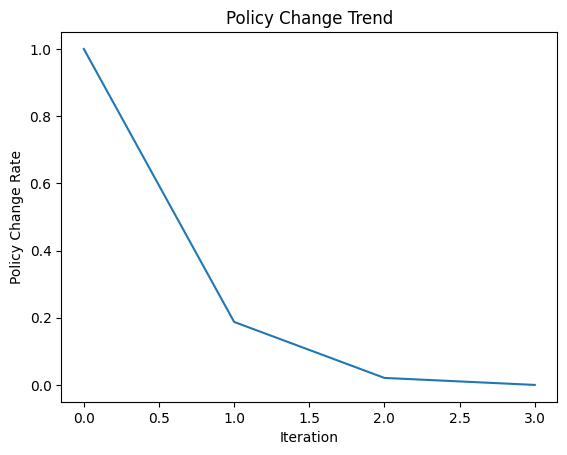

In [ ]:
plt.plot(policy_change_rates)
plt.xlabel("Iteration")
plt.ylabel("Policy Change Rate")
plt.title("Policy Change Trend")
plt.show()

# 02. 가치 이터레이션
- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.

In [ ]:
class ValueIteration:
    def __init__(self, env):

        self.env = env
        self.action_space = env.action_space
        self.num_actions = env.num_actions

        # value 2d list
        self.value_table = np.zeros(shape=(env.height, env.width)).tolist()

        self.gamma = 0.9

    def value_iteration(self):
        threshold = 1e-4
        while True:
          delta = 0
          for r in range(self.env.height):
            for c in range(self.env.width):
              if (r,c) == tuple(self.env.end_point): continue
              old_val = self.value_table[r][c]
              new_val = 0
              for a in range(self.num_actions):

                next_state = self.env.state_after_action((r,c), a)
                reward = self.env.get_reward(next_state, a)
                q_val = reward + self.gamma * self.value_table[next_state[0]][next_state[1]]
                new_val = max(new_val, q_val)
              self.value_table[r][c] = new_val
              delta = max(delta, abs(old_val - new_val))
          if delta < threshold:
            break

    def get_action(self, state):
      max_q = -float('inf')
      best_action = 0
      for a in range(self.num_actions):
          next_state = self.env.state_after_action(state, a)
          reward = self.env.get_reward(state, a)
          q_value = reward + self.gamma * self.value_table[next_state[0]][next_state[1]]
          if q_value > max_q:
              max_q = q_value
              best_action = a
      return best_action


    def get_value(self, state):
        return self.value_table[state[0]][state[1]]

## 가치 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

In [ ]:
env = MyGridWorldEnv(start_point=(0,0), end_point=(4,4), grid_world_size=(5,5))
value_it = ValueIteration(env)

value_diff_list = []

iteration = 0
max_iterations = 100

while True:
    iteration += 1
    print(f"{iteration}회차 반복 중...")

    value_it.value_iteration()

    # 이전 기대값 저장
    old_value_table = copy.deepcopy(value_it.value_table)

    # 1. 기대값 반복 수행 후, 값이 수렴했는지 체크
    value_it.value_iteration()

    # 2. 기대값 차이 최대값 계산
    max_diff = 0
    for r in range(env.height):
        for c in range(env.width):
            diff = abs(value_it.value_table[r][c] - old_value_table[r][c])
            max_diff = max(max_diff, diff)
    value_diff_list.append(max_diff)

    # 3. 수렴 조건 체크
    if max_diff < 1e-4:
        print("수렴 완료!")
        break
    if iteration >= max_iterations:
        print("반복횟수 제한 도달")
        break

print()
print('=====================================================================')

print("✳ 최적 기대값 (각 위치별 기대값):")
height = env.height
width = env.width

print("     ", end="")
for c in range(width):
    print(f" {c:6}    ", end="")
print()  # 줄바꿈 후 헤더 끝

print("    +" + "-----------" * width)  # 구분선

# 각 행별 표시
for r in range(height):
    # 행 인덱스 출력
    print(f"{r:3} |", end="")

    # 각 열값 출력
    for c in range(width):
        print(f" {value_it.value_table[r][c]:6.8f}", end="")
    print()
print()
print('=====================================================================')

print("✳ 상태별, 행동별 기대값 (Q-값):")

q_value_table = np.zeros((env.height, env.width, env.action_space.__len__()))

for r in range(env.height):
    for c in range(env.width):
        state = (r, c)
        print(f"\n상태: {state}")
        for a in range(value_it.num_actions):
            next_state = env.state_after_action(state, a)
            reward = env.get_reward(state, a)
            q_value = reward + value_it.gamma * value_it.value_table[next_state[0]][next_state[1]]
            action_name = env.action_space[a]
            print(f"  행동: {action_name:>5} | 기대값(Q): {q_value:.3f}")

1회차 반복 중...
수렴 완료!

✳ 최적 기대값 (각 위치별 기대값):
           0          1          2          3          4    
    +-------------------------------------------------------
  0 | 2.79674160 3.10755744 3.45290170 3.83661153 4.26295038
  1 | 3.10755744 3.45290170 3.83661153 4.26295038 4.73665534
  2 | 3.45290170 3.83661153 4.26295038 4.73665534 5.26298980
  3 | 3.83661153 4.26295038 4.73665534 4.26298980 4.73669082
  4 | 4.26295038 4.73665534 5.26298980 4.73669082 0.00000000

✳ 상태별, 행동별 기대값 (Q-값):

상태: (0, 0)
  행동:    up | 기대값(Q): 2.517
  행동:  down | 기대값(Q): 2.797
  행동:  left | 기대값(Q): 2.517
  행동: right | 기대값(Q): 2.797

상태: (0, 1)
  행동:    up | 기대값(Q): 2.797
  행동:  down | 기대값(Q): 3.108
  행동:  left | 기대값(Q): 2.517
  행동: right | 기대값(Q): 3.108

상태: (0, 2)
  행동:    up | 기대값(Q): 3.108
  행동:  down | 기대값(Q): 3.453
  행동:  left | 기대값(Q): 2.797
  행동: right | 기대값(Q): 3.453

상태: (0, 3)
  행동:    up | 기대값(Q): 3.453
  행동:  down | 기대값(Q): 3.837
  행동:  left | 기대값(Q): 3.108
  행동: right | 기대값(Q): 3.837

상태: (0, 4)


## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터/요소를 찾아 시각화해 주세요.

In [ ]:
# value 값 변화량

import matplotlib.pyplot as plt
import numpy as np
import copy

env = MyGridWorldEnv(start_point=(0,0), end_point=(4,4), grid_world_size=(5,5))
value_it2 = ValueIteration(env)

value_diff_list = []

max_iterations = 50  # 최대 반복 횟수

for i in range(max_iterations):
    old_value_table = copy.deepcopy(value_it2.value_table)  # 이전 기대값 저장

    # 기대값 반복 업데이트 (벨만 기대 방정식)
    # 이 부분은 이미 정의된 value_iteration() 내부에서 수행된다고 가정하거나,
    # 별도로 호출하는 함수를 사용하세요.
    value_it2.value_iteration()
    # 또는, 값 업데이트 로직이 별도라면, 호출하시면 됨.

    # 현재값과 이전값 차이 최대값 계산
    max_diff = 0
    for r in range(env.height):
        for c in range(env.width):
            diff = abs(value_it2.value_table[r][c] - old_value_table[r][c])
            max_diff = max(max_diff, diff)
    value_diff_list.append(max_diff)

    # 수렴 조건 체크
    if max_diff < 1e-4:
        print("Converged!")
        break

Converged!


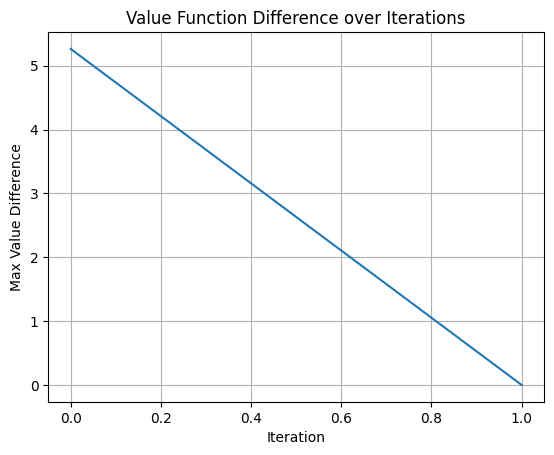

In [ ]:
plt.plot(value_diff_list)
plt.xlabel('Iteration')
plt.ylabel('Max Value Difference')
plt.title('Value Function Difference over Iterations')
plt.grid(True)
plt.show()